Loading movies metadata...
Loaded credits.csv


C:\Users\msasr\AppData\Local\Temp\ipykernel_26844\4088434845.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credits_small['id'] = credits_small['id'].astype(str)


Train size: (6056, 22) Test size: (1371, 22)
Ridge eval: {'RMSE': np.float64(172262308.82807222), 'MAE': 55148085.3187261, 'R2': 0.2563567325853495}
RandomForest eval: {'RMSE': np.float64(93187965.40349436), 'MAE': 42893946.710074626, 'R2': 0.782377506333257}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 6056, number of used features: 22
[LightGBM] [Info] Start training from score 16.008390
LightGBM eval: {'RMSE': np.float64(95324475.10823867), 'MAE': 42874528.917460434, 'R2': 0.772284303320444}


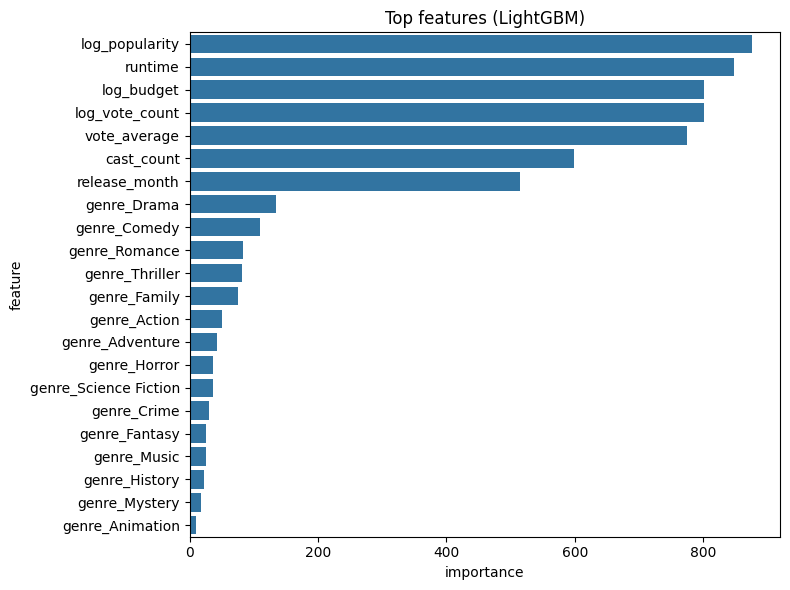

Saved features to movie_features_for_powerbi.csv
RF (metadata-only) eval: {'RMSE': np.float64(117577978.6281007), 'MAE': 50892285.907646544, 'R2': 0.6535535606686251}
RF (metadata+genres) eval: {'RMSE': np.float64(93187965.40349433), 'MAE': 42893946.71007462, 'R2': 0.7823775063332571}


In [3]:
# movies_boxoffice_pipeline.py
# Usage: run in Jupyter or as a script (if in script, ensure printing works)
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- 1. Files (put these CSVs in working dir) ----------
# Preferred Kaggle dataset: "The Movies Dataset" (movies_metadata.csv).
# Optionally include credits.csv to compute cast_count.
DATA_DIR = Path(".")
MOVIES_CSV = DATA_DIR / "movies_metadata.csv"   # from Kaggle
CREDITS_CSV = DATA_DIR / "credits.csv"          # optional (for cast_count)

# ---------- 2. Load data ----------
print("Loading movies metadata...")
movies = pd.read_csv(MOVIES_CSV, low_memory=False)

# optional credits for cast count
try:
    credits = pd.read_csv(CREDITS_CSV)
    credits_available = True
    print("Loaded credits.csv")
except Exception:
    credits_available = False
    print("credits.csv not found; continuing without cast_count")

# ---------- 3. Basic cleaning & parsing ----------
# Keep only movies that have a numeric release date and numeric revenue/budget
# Column names/format depend on Kaggle variant; adapt if necessary
def safe_numeric(s):
    try:
        return float(s)
    except Exception:
        return np.nan

# Some Kaggle files store 'budget' and 'revenue' as strings; coerce
movies['budget'] = pd.to_numeric(movies.get('budget', np.nan), errors='coerce')
movies['revenue'] = pd.to_numeric(movies.get('revenue', np.nan), errors='coerce')

# parse release_date -> year & month
movies['release_date'] = pd.to_datetime(movies['release_date'], errors='coerce')
movies['release_year'] = movies['release_date'].dt.year
movies['release_month'] = movies['release_date'].dt.month

# drop rows without revenue (we need target) or without release year
movies = movies.dropna(subset=['revenue', 'release_year'])
movies = movies[movies['revenue'] > 0]  # keep positive revenue rows
movies = movies[movies['budget'] >= 0]  # budgets that are zero or positive

# ---------- 4. Feature engineering ----------
# 4.1 genres: movies['genres'] is JSON-like string -> extract names
import ast
def parse_genres(genres_str):
    if pd.isna(genres_str): return []
    try:
        data = ast.literal_eval(genres_str)
        return [g['name'] for g in data] if isinstance(data, list) else []
    except Exception:
        return []
movies['genres_list'] = movies['genres'].apply(parse_genres)
# create top-K genre dummies (or multi-hot)
genres_exploded = movies['genres_list'].explode()
top_genres = genres_exploded.value_counts().head(15).index.tolist()
for g in top_genres:
    movies[f'genre_{g}'] = movies['genres_list'].apply(lambda lst: int(g in lst))

# 4.2 runtime, popularity, vote_average, vote_count
movies['runtime'] = pd.to_numeric(movies.get('runtime', np.nan), errors='coerce')
movies['vote_average'] = pd.to_numeric(movies.get('vote_average', np.nan), errors='coerce')
movies['vote_count'] = pd.to_numeric(movies.get('vote_count', np.nan), errors='coerce')
movies['popularity'] = pd.to_numeric(movies.get('popularity', np.nan), errors='coerce')

# 4.3 cast_count from credits.csv (if available)
if credits_available:
    credits['cast_count'] = credits['cast'].apply(lambda s: len(ast.literal_eval(s)) if pd.notna(s) else 0)
    credits_small = credits[['id','cast_count']]
    # note: in some Kaggle versions id is string, cast.id mapping may need normalization
    # merge on 'id' vs movies['id'] (movies 'id' column might be string)
    movies['id'] = movies['id'].astype(str)
    credits_small['id'] = credits_small['id'].astype(str)
    movies = movies.merge(credits_small, on='id', how='left')
else:
    movies['cast_count'] = np.nan

# 4.4 log transforms (reduce skew): budget, popularity, vote_count
movies['log_budget'] = np.log1p(movies['budget'].fillna(0))
movies['log_popularity'] = np.log1p(movies['popularity'].fillna(0))
movies['log_vote_count'] = np.log1p(movies['vote_count'].fillna(0))

# 4.5 target: opening_weekend not in Kaggle; use total revenue (or use external dataset)
# We'll predict 'revenue' (total box office)
movies['target_revenue'] = movies['revenue']

# 4.6 keep features list
BASE_FEATURES = [
    'log_budget', 'runtime', 'release_month', 'log_popularity', 'vote_average',
    'log_vote_count', 'cast_count'
] + [f'genre_{g}' for g in top_genres]

# fill NA
movies[BASE_FEATURES] = movies[BASE_FEATURES].fillna(0)

# ---------- 5. Train/test split (time-aware) ----------
# Use older movies to train, recent movies to test to mimic real-world
cutoff_year = int(movies['release_year'].quantile(0.8))  # top 20% newest as test
train = movies[movies['release_year'] <= cutoff_year].copy()
test  = movies[movies['release_year'] > cutoff_year].copy()

X_train = train[BASE_FEATURES]
y_train = np.log1p(train['target_revenue'])  # log-transform target for stability
X_test  = test[BASE_FEATURES]
y_test  = np.log1p(test['target_revenue'])

print("Train size:", X_train.shape, "Test size:", X_test.shape)

# ---------- 6. Baseline models & evaluation helpers ----------
def evaluate(y_true_log, y_pred_log):
    # inputs are log1p transformed; convert back to original scale for metrics
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# 6.1 Ridge baseline
num_cols = ['log_budget','runtime','log_popularity','vote_average','log_vote_count','cast_count']
preproc = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('pass', 'passthrough', [c for c in BASE_FEATURES if c not in num_cols])
])
ridge_pipe = Pipeline([('pre', preproc), ('model', Ridge(alpha=1.0))])
ridge_pipe.fit(X_train, y_train)
pred_ridge = ridge_pipe.predict(X_test)
print("Ridge eval:", evaluate(y_test, pred_ridge))

# 6.2 Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print("RandomForest eval:", evaluate(y_test, pred_rf))

# 6.3 LightGBM (quick train)
dtrain = lgb.Dataset(X_train, label=y_train)
params = {'objective':'regression','metric':'rmse','learning_rate':0.05,'num_leaves':31}
bst = lgb.train(params, dtrain, num_boost_round=200)
pred_lgb = bst.predict(X_test)
print("LightGBM eval:", evaluate(y_test, pred_lgb))

# ---------- 7. Feature importance (LGB) ----------
fi = pd.DataFrame({'feature': X_train.columns, 'importance': bst.feature_importance()})
fi = fi.sort_values('importance', ascending=False).head(25)
plt.figure(figsize=(8,6))
sns.barplot(data=fi, x='importance', y='feature')
plt.title('Top features (LightGBM)')
plt.tight_layout()
plt.show()

# ---------- 8. Save features for Power BI ----------
OUT_CSV = "movie_features_for_powerbi.csv"
# Save selected columns + target (original revenue)
export_cols = ['id','title','release_date','release_year','runtime','budget','revenue','target_revenue'] + BASE_FEATURES
# Some Kaggle variants differ in column names — guard:
export_cols = [c for c in export_cols if c in movies.columns]
movies[export_cols].to_csv(OUT_CSV, index=False)
print("Saved features to", OUT_CSV)

# ---------- 9. Quick ablation: metadata vs metadata+genres ----------
# Simple demonstration: metadata-only features
meta_feats = ['log_budget','runtime','release_month','vote_average']
Xtr_meta = X_train[meta_feats]; Xte_meta = X_test[meta_feats]
rf_meta = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_meta.fit(Xtr_meta, y_train)
print("RF (metadata-only) eval:", evaluate(y_test, rf_meta.predict(Xte_meta)))
# metadata + genres
rf_gen = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_gen.fit(X_train, y_train)
print("RF (metadata+genres) eval:", evaluate(y_test, rf_gen.predict(X_test)))

# End
